### Wall of Imports

In [1]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.documents.base import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken
import getVectorstore 
from getVectorstore import getVectorstore
from qdrant_client.http import models as rest
from dotenv import load_dotenv
import os, getpass, time
import prompts
from prompts import rag_prompt_template
from langchain.prompts import ChatPromptTemplate
from defaults import default_llm
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from datetime import date
import queries
from queries import summary_query
from queries import background_query
from queries import number_of_participants_query
from queries import study_procedures_query
from queries import alt_procedures_query
from queries import risks_query
from queries import benefits_query
import makeMarkdown
from makeMarkdown import makeMarkdown
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import HumanMessage




### Get the API key(s)

In [2]:
# Usual method to get the key
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
# Backup method in case above did not work
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

#### Get protocol reference, vectorize and store in Qdrant

In [3]:
# Load the document - here we are just using a protocol in a specific directory
# In the demo project this will come from Jeeva's code
file_path = './documents/protocol.pdf'
# file_path = './documents/consent.pdf'
separate_pages = []             
loader = PyMuPDFLoader(file_path)
page = loader.load()
separate_pages.extend(page)
print(f"Number of separate pages: {len(separate_pages)}")

# OyMuPDFLoader loads pages into separate docs!
# This is a problem when we chunk because we only chunk individual
# documents.  We need ONE overall document so that the chunks can
# overlap between actual PDF pages.
document_string = ""
for page in separate_pages:
    document_string += page.page_content
print(f"Length of the document string: {len(document_string)}")

# CHOP IT UP
def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap = 200,
    length_function = tiktoken_len
)
text_chunks = text_splitter.split_text(document_string)
print(f"Number of chunks: {len(text_chunks)} ")
document = [Document(page_content=chunk) for chunk in text_chunks]
print(f"Length of  document: {len(document)}")

qdrant_vectorstore = getVectorstore(document, file_path)

Number of separate pages: 76
Length of the document string: 189621
Number of chunks: 28 
Length of  document: 28
Collection exists
Added 0 new documents
Skipped 28 existing documents


## Build the RAG Chain - need retriever, prompt, and LLM

In [4]:
# Helper function that lets me create a retriever for a specific document
"""
This code sets up the search type but more importantly it has the filter
set up correctly.  We get a list of document titles that we want to include
in the filter, and pass it into the function, returning the retriever.

"""

def create_protocol_retriever(document_titles):
    return qdrant_vectorstore.as_retriever(
        search_kwargs={
            'filter': rest.Filter(
                must=[
                    rest.FieldCondition(
                        key="metadata.document_title",
                        match=rest.MatchAny(any=document_titles)
                    )
                ]
            ),
            'k': 15,                                       
        }
    )

# Usage example
# document_titles = ["consent.pdf", "protocol.pdf"]
document_titles = ["protocol.pdf"]
protocol_retriever = create_protocol_retriever(document_titles)

# Create prompt
rag_prompt = ChatPromptTemplate.from_template(prompts.rag_prompt_template)

llm = default_llm

rag_chain = (
    {"context": itemgetter("question") | protocol_retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

## Static sections that do not need rag_chain calls 
- Heading for the top of the informed consent document
- Boilerplate text that is the same for all ICF's
- Part 2 of the ICF which is site specific and needs to be created by the tool

In [5]:
# Heading for top of ICF document
protocol_title = rag_chain.invoke({"question": "What is the exact title of this protocol?  Only return the title itself without any other description."})
principal_investigator = rag_chain.invoke({"question":"What is the name of the principal investigator of the study?  Only return the name itself without any other description."})
support = rag_chain.invoke({"question":"What agency is funding the study?  Only return the name of the agency without any other description."})
version_date = date.today().strftime("%B %d, %Y")

heading = f""" 
## Parental Permission, Teen Assent and Authorization Document

**Study Title:** {protocol_title}

**Principal Investigator:** {principal_investigator}

**Version Date:** {version_date}

**Source of Support:** {support}

---

<div style="text-align: center;">

## Part 1 of 2: MASTER CONSENT
</div>

**Parents/Guardians:**
You have the option of having your child or teen join a research study.
This is a parental permission form. It provides a summary of the information the research team
will discuss with you. If you decide that your child can take part in this study, you would sign
this form to confirm your decision. If you sign this form, you will receive a signed copy for your
records. *The word “you” in this form refers to your child/teen unless otherwise indicated.*

**Assent Teen Participants:**
This form also serves as an assent form. That means that if you
choose to take part in this research study, you would sign this form to confirm your choice. Your
parent or guardian would also need to give their permission and sign this form for you to join the
study

**Consent for Continued Participation (Participants who turn 18 during the study):**
This is a consent form for continued participation. It provides a summary of the information the
research team will discuss with you. If you decide that you would like to continue participating in
this research study, you would sign this form to confirm your decision. If you sign this form, you
will receive a signed copy of this form for your records.

---

""" 

In [6]:
# Boilerplate that goes after the generated portions of ICF
boilerplate = """ 
## Right of the Investigator to Withdraw Participants
The investigator can withdraw you from the study without your approval.  If at any time the
investigator believes participating in the study is not the best choice of care, the study
may be stopped and other care prescribed.  If unexpected medical problems come up, the investigator
may decide to stop your participation in the study.

---
## New Information
Sometimes during the course of a research project, new information becomes available about the
drugs that are being studied. If this happens, your research doctor will tell you about it and discuss
with you whether you want to continue in the study. If you decide to continue in the study, you
may be asked to sign an updated consent form. Also, on receiving new information the research
doctor might consider it to be in your best interests to withdraw you from the study. He/she will
explain the reasons and arrange for your medical care to continue.

---

## Costs and Compensation to Participants
While you are in this study, the cost of your usual medical care - procedures, medications and
doctor visits - will continue to be billed to you or your insurance. There will be no additional costs
to you for your participation in this study. You will receive up to \$50 to compensate you for your
time when completing the follow-up surveys at the 3- and 12-month time points. You will receive
\$25 for each follow-up period once we receive your answers to the surveys. Any tests that are
performed or medications administered solely for the purposes of being in this study will be paid
for by the research doctor. The National Institutes of Health is providing funding for this study.

---

## Single IRB Contact
**Institutional Review Board:** The University of Utah Institutional Review Board (IRB) is
serving as the single IRB (SIRB) for this study. Contact the SIRB if you have questions, complaints
or concerns which you do not feel you can discuss with the investigator. The University of Utah
IRB may be reached by phone at (801) 581-3655 or 
by e-mail at irb@hsc.utah.edu.

"""

In [7]:
# Heading for Part 2 of the ICF document, which is the local context part
part2 = f""" 
## Parental Permission, Teen Assent and Authorization Document

**Study Title:** {protocol_title}

**Principal Investigator:** {principal_investigator}

**Source of Support:** {support}

---

<div style="text-align: center;">

## Part 2 of 2: SITE SPECIFIC INFORMATION
</div>

This section of the consent form, as well as signature pages, are very specific
to individual sites, and the Clinical Trial Accelerator does not have the ability
to create this section.principal_investigator

---

"""

## Generate everything without agents
- Summary
- Background
- Number of participants
- Study procedures
- Alternative procedures
- Risks
- Benefits

In [8]:
start_time = time.time()
# Brute force method that just saves each generated section as string
summary = rag_chain.invoke({"question":summary_query()})
background = rag_chain.invoke({"question":background_query()})
number_of_participants = rag_chain.invoke({"question":number_of_participants_query()})
study_procedures = rag_chain.invoke({"question":study_procedures_query()})
alt_procedures = rag_chain.invoke({"question":alt_procedures_query()})
risks = rag_chain.invoke({"question":risks_query()})
benefits = rag_chain.invoke({"question":benefits_query()})

end_time = time.time()
execution_time = end_time - start_time
print(f"Brute force (sequential) execution time: {execution_time:.2f} seconds.")

Brute force (sequential) execution time: 86.90 seconds.


### Combine all pieces of the consent into one document and save to markdown file

In [9]:
# Put the pieces in a list and pass it to makeMarkdown
pieces_of_consent = [
    heading,
    summary,
    background,
    number_of_participants,
    study_procedures,
    alt_procedures,
    risks,
    benefits,
    boilerplate,
    part2
]
ICF_title = "Non-Agent Written ICF"         # need to make this interactive
makeMarkdown(pieces_of_consent, ICF_title)
print("Done")

 
## Parental Permission, Teen Assent and Authorization Document

**Study Title:** PeRsonalizEd immunomodulation in pediatriC sepsIS-inducEd MODS (PRECISE)

**Principal Investigator:** Mark W. Hall

**Version Date:** October 14, 2024

**Source of Support:** Eunice Kennedy Shriver National Institute for Child Health and Human Development (NICHD)

---

<div style="text-align: center;">

## Part 1 of 2: MASTER CONSENT
</div>

**Parents/Guardians:**
You have the option of having your child or teen join a research study.
This is a parental permission form. It provides a summary of the information the research team
will discuss with you. If you decide that your child can take part in this study, you would sign
this form to confirm your decision. If you sign this form, you will receive a signed copy for your
records. *The word “you” in this form refers to your child/teen unless otherwise indicated.*

**Assent Teen Participants:**
This form also serves as an assent form. That means that if you
choose to take part in this research study, you would sign this form to confirm your choice. Your
parent or guardian would also need to give their permission and sign this form for you to join the
study

**Consent for Continued Participation (Participants who turn 18 during the study):**
This is a consent form for continued participation. It provides a summary of the information the
research team will discuss with you. If you decide that you would like to continue participating in
this research study, you would sign this form to confirm your decision. If you sign this form, you
will receive a signed copy of this form for your records.

---



---

## Study Summary

You are being invited to allow your child to participate in a research study because your child is potentially eligible due to their admission to the Pediatric or Cardiac Intensive Care Unit with sepsis-induced multiple organ dysfunction syndrome (MODS). This study, known as the PRECISE study, aims to explore new ways to treat children with sepsis-induced MODS by personalizing their care based on their immune system's response to infection.

Sepsis is a serious condition that occurs when the body's response to an infection causes injury to its own tissues and organs. In some cases, this can lead to multiple organ dysfunction syndrome (MODS), where two or more organ systems in the body stop working properly. The current treatment for sepsis primarily involves antibiotics and supportive care, such as fluids and medications to support blood pressure. However, these treatments are not tailored to the specific needs of each child, and there is a need for more personalized approaches.

The PRECISE study is designed to address this need by identifying specific immune system patterns, or "phenotypes," in children with sepsis-induced MODS. By understanding these patterns, researchers hope to provide treatments that are more closely aligned with each child's unique immune response. The study involves two main trials: the GRACE-2 trial, which tests a drug called GM-CSF to boost the immune system, and the TRIPS trial, which tests a drug called anakinra to reduce inflammation. Both drugs are being compared to a placebo, which is a substance with no active medication, to determine their effectiveness.

Participation in this study is entirely voluntary, and you can choose to withdraw your child at any time without affecting their medical care. If you decide to allow your child to participate, they will undergo a series of tests to determine their immune phenotype. Based on these results, they may be enrolled in one of the trials or placed in an observational group if they do not meet the criteria for the trials.

There are potential risks and benefits to participating in this study. The risks include possible side effects from the study drugs, such as fever, chills, or allergic reactions. There is also a risk of discomfort from blood draws and other procedures. However, the study is designed to minimize these risks, and your child's health will be closely monitored throughout the study.

The potential benefits of participating include access to new treatments that may improve your child's condition and contribute to medical knowledge that could help other children in the future. While there is no guarantee that your child will benefit directly from the study, the information gained may lead to better treatments for sepsis-induced MODS.

Your decision to allow your child to participate should be based on a careful consideration of the potential risks and benefits. If you have any questions or concerns, the study team is available to provide more information and support. Your child's participation is important, but it is entirely your choice, and your decision will be respected regardless of whether you choose to participate.

---

## Background

You are being invited to participate in a research study focused on improving the treatment of sepsis-induced multiple organ dysfunction syndrome (MODS) in children. Sepsis is a serious medical condition that occurs when the body's response to an infection causes widespread inflammation, leading to organ failure. MODS is a severe complication of sepsis where multiple organs in the body stop functioning properly. This condition is life-threatening and requires intensive medical care.

The study you are being considered for is called the PRECISE study, which stands for PeRsonalizEd immunomodulation in pediatriC sepsIS-inducEd MODS. The goal of this study is to explore new ways to treat sepsis-induced MODS by tailoring treatments to the specific immune responses of individual patients. This personalized approach is based on the understanding that children with sepsis can have different immune system reactions, which may require different treatment strategies.

In this study, researchers are investigating two main treatment strategies. The first strategy involves using a drug called GM-CSF (granulocyte-macrophage colony-stimulating factor) to boost the immune system in children whose immune response is too weak. GM-CSF is a naturally occurring protein in the body that helps stimulate the production of white blood cells, which are crucial for fighting infections. By enhancing the immune response, the researchers hope to improve the body's ability to clear infections and recover from organ dysfunction.

The second strategy involves using a drug called anakinra to reduce excessive inflammation in children whose immune response is too strong. Anakinra is a medication that blocks the activity of a specific protein called interleukin-1, which plays a key role in the inflammatory process. By reducing inflammation, the researchers aim to prevent further damage to the organs and promote healing.

The scientific basis for these interventions comes from previous studies that have shown distinct immune system patterns in children with sepsis-induced MODS. Some children exhibit a suppressed immune response, making them more vulnerable to infections, while others show signs of excessive inflammation, which can lead to further organ damage. By identifying these patterns, the researchers believe they can provide more effective and targeted treatments.

Your participation in this study could contribute to a better understanding of how personalized treatments can improve outcomes for children with sepsis-induced MODS. The knowledge gained from this research may help develop new treatment guidelines and improve the care of critically ill children in the future.

---

## Number of Participants

This study, titled "PeRsonalizEd immunomodulation in pediatriC sepsIS-inducEd MODS (PRECISE)," is being conducted across multiple hospitals within the Collaborative Pediatric Critical Care Research Network (CPCCRN). The network includes renowned institutions such as Children's Hospital of Colorado, Children's Hospital of Los Angeles, and Nationwide Children's Hospital, among others. The study is funded by the Eunice Kennedy Shriver National Institute of Child Health and Human Development (NICHD). The protocol aims to enroll up to 1,095 participants to achieve the target of 500 patients for the TRIPS trial component. Enrollment is expected to occur over a period that aligns with the study's objectives, although the exact duration is not specified in the provided context. Participants will be critically ill children with sepsis-induced multiple organ dysfunction syndrome (MODS), and the study will explore personalized immune modulation strategies to improve outcomes.

---

## Study Procedures

In this study, we will conduct a series of procedures to understand and potentially improve outcomes for children with sepsis-induced multiple organ dysfunction syndrome (MODS). Below, we outline the steps and procedures you will undergo if you decide to participate in this study.

### Screening and Enrollment

Upon admission to the pediatric or cardiac intensive care unit (ICU), we will evaluate your eligibility for the study. If you meet the inclusion criteria and no exclusion criteria are present, we will approach your legal guardian(s) to discuss participation. If they agree, you will be enrolled in the study, and we will proceed with the next steps.

### Immune Phenotyping

On the second day after the onset of sepsis-induced MODS, we will perform immune phenotyping. This involves taking a small blood sample (approximately 2 ml) to measure your immune response and levels of certain inflammatory markers, such as serum ferritin and C-reactive protein (CRP). The blood sample will be stimulated on-site and then shipped to a specialized laboratory for analysis. This process helps us determine your immune status and decide the appropriate study intervention.

### Randomization and Study Drug Administration

Based on the results of your immune phenotyping, you may be eligible for one of two trials: the GRACE-2 trial or the TRIPS trial. If you qualify, you will be randomly assigned to receive either the study drug or a placebo. The study drug will be administered intravenously over a specified period, and the dosage will depend on your specific immune profile.

#### GRACE-2 Trial

If you are enrolled in the GRACE-2 trial, you will receive GM-CSF or a placebo. The drug will be infused over at least six hours daily for seven days. We will monitor your white blood cell count to ensure it remains within safe limits.

#### TRIPS Trial

If you are enrolled in the TRIPS trial, you will receive anakinra or a placebo. The drug will be administered every 12 hours for seven days. We will adjust the dose if you have severe renal dysfunction to ensure safety.

### Follow-up Immune Function Testing

Throughout the study, we will conduct follow-up immune function tests to monitor your response to the study drug. These tests will include additional blood samples taken twice weekly for two weeks. The samples will be processed locally and shipped to the laboratory for analysis. This will help us understand how the study drug affects your immune system and overall health.

### Biorepository Sample Collection

We will collect additional biological samples, such as serum, plasma, RNA, and DNA, for future research. These samples will be stored in a biorepository and may be used to study the biology of immune function and inflammation in children with sepsis-induced MODS. You will have the option to consent to the use of these samples for future studies unrelated to this protocol.

### Data Collection and Monitoring

We will collect various data throughout the study, including demographic information, eligibility data, and daily health status. We will also monitor any adverse events or changes in your condition. This data will help us assess the effectiveness and safety of the study interventions.

### Discontinuation or Withdrawal

You may discontinue the study drug if an adverse event occurs or if your legal guardians request it. If you withdraw from the study, we will stop all study procedures and data collection, but we will continue to review any data collected before your withdrawal.

### Quality of Life Assessments

We will assess your quality of life using specific instruments at the beginning of the study and at follow-up intervals. These assessments will help us understand the impact of the study interventions on your overall well-being.

### Conclusion

These procedures are designed to help us better understand and potentially improve the treatment of sepsis-induced MODS in children. Your participation is crucial in advancing our knowledge and developing more effective therapies.

---

## Alternative Procedures

Your participation in this study is entirely voluntary. You do not need to be part of this study to receive high-quality care for sepsis-induced multiple organ dysfunction syndrome (MODS) in a pediatric intensive care unit. The medical team will continue to provide state-of-the-art critical care based on current medical standards, regardless of your decision to participate. This includes the use of antibiotics and supportive care measures such as fluid resuscitation and the use of medications to support heart and lung function. 

Currently, monitoring of immune function and personalized immunomodulation treatments are not part of routine care in pediatric ICUs. The study aims to explore whether specific treatments can improve outcomes by targeting the immune system, but these treatments are not yet standard practice. If you choose not to participate, your child will still receive all the necessary medical interventions that are typically used to manage sepsis and MODS. 

You can decide to stop participating in the study at any time, and this will not affect the care your child receives. If you choose to withdraw from the study, the medical team will continue to provide all necessary treatments as per standard care protocols. Your decision to participate or not will not impact the quality of care your child receives in any way.

---

## Risks

Participating in this study involves several risks that you should be aware of before deciding to take part. These risks are associated with the study drugs, procedures, and data collection. While we have taken steps to minimize these risks, it is important to understand them fully. Additionally, there may be unforeseeable risks that we cannot predict at this time.

### Risks Associated with Study Drugs

#### GM-CSF (Granulocyte Macrophage-Colony Stimulating Factor)

GM-CSF is a medication used to stimulate the production of white blood cells. It is generally safe, but there are some risks associated with its use:

- **Fever and Chills**: You may experience fever and chills as your body responds to the medication.
- **Bone Pain**: Some participants report bone pain, which is usually mild and temporary.
- **Dyspnea (Difficulty Breathing)**: There is a small risk of experiencing difficulty breathing.
- **Tachycardia (Increased Heart Rate)**: Your heart rate may increase temporarily.
- **Peripheral Edema (Swelling)**: Rapid infusion of GM-CSF can cause swelling in the limbs.
- **Pericardial Effusion (Fluid Around the Heart)**: Although rare, there is a risk of fluid accumulation around the heart.
- **Hypersensitivity Reactions**: Allergic reactions, including rash and itching, may occur.

#### Anakinra

Anakinra is used to reduce inflammation by blocking a specific protein in the body. It is generally well-tolerated, but there are potential risks:

- **Increased Risk of Infection**: Anakinra can increase the risk of infections, as it affects the immune system.
- **Neutropenia (Low White Blood Cell Count)**: This condition can make you more susceptible to infections.
- **Hypersensitivity Reactions**: Rarely, severe allergic reactions such as anaphylaxis can occur.
- **Injection Site Reactions**: Although not applicable in this study due to intravenous administration, it is important to be aware of potential reactions.

### Risks Associated with Biological Sampling

#### Blood Sampling

Blood samples will be collected as part of the study. The risks associated with blood sampling include:

- **Pain and Bruising**: You may experience pain and bruising at the site where blood is drawn.
- **Bleeding**: There is a small risk of bleeding, especially if you have a bleeding disorder.
- **Infection**: Although rare, there is a risk of infection at the site of blood draw.
- **Anemia**: Frequent blood sampling can lead to a low red blood cell count, known as anemia.

#### Tracheal Aspirates

For participants with a breathing tube, tracheal aspirates may be collected:

- **Discomfort**: The procedure may cause discomfort or coughing.
- **Bleeding**: There is a small risk of bleeding from the airway.
- **Infection**: The procedure may increase the risk of respiratory infections.

### Risks Associated with Data Collection

#### Loss of Confidentiality

While we take extensive measures to protect your personal information, there is a minimal risk of loss of confidentiality. Your data will be stored securely, and only authorized personnel will have access to it.

### Unforeseeable Risks

As with any clinical study, there may be risks that we cannot predict at this time. These unforeseeable risks could arise from the study drugs, procedures, or other aspects of the study. We will monitor all participants closely and inform you of any new risks that are identified during the study.

### Conclusion

It is important to weigh these risks against the potential benefits of participating in the study. If you have any questions or concerns about these risks, please discuss them with the study team. Your safety and well-being are our top priorities, and we are committed to providing you with all the information you need to make an informed decision.

---

## Benefits

### Potential Benefits for You

Participating in this study may offer you potential benefits, although it is important to understand that the effectiveness of the interventions being tested is not yet known. The primary goal of this study is to improve outcomes for children with sepsis-induced multiple organ dysfunction syndrome (MODS) by using personalized immunomodulation strategies. If you are enrolled in the GRACE-2 trial, you may receive granulocyte macrophage-colony stimulating factor (GM-CSF), which is being investigated for its potential to reverse immunoparalysis and enhance your immune response. This could potentially lead to a reduction in the duration and severity of organ dysfunction, and possibly improve your overall recovery from sepsis-induced MODS.

If you are enrolled in the TRIPS trial, you may receive anakinra, a medication that targets inflammation. This intervention is being studied for its potential to reduce systemic inflammation and improve outcomes in children with sepsis-induced MODS. By participating, you may experience a reduction in inflammation, which could contribute to a faster resolution of organ dysfunction and potentially improve your quality of life during and after recovery.

It is important to note that while these potential benefits exist, they are not guaranteed, as the study is designed to evaluate the effectiveness of these interventions. Your participation will be closely monitored by a team of healthcare professionals to ensure your safety throughout the study.

### Potential Benefits for Others

Your participation in this study has the potential to benefit others by contributing to the advancement of medical knowledge and treatment strategies for sepsis-induced MODS in children. The information gathered from this study will help researchers and healthcare providers better understand the immune responses in pediatric sepsis and the effectiveness of targeted immunomodulation therapies.

By participating, you are helping to pave the way for future treatments that could improve the outcomes for other children who develop sepsis-induced MODS. The insights gained from this study may lead to more personalized and effective treatment approaches, potentially reducing mortality and morbidity associated with this condition.

Additionally, the study's findings may inform clinical guidelines and practices, ultimately enhancing the standard of care for critically ill children with sepsis. Your involvement in this research is a valuable contribution to the scientific community and may have a lasting impact on the health and well-being of children worldwide.

In summary, while the direct benefits to you are not guaranteed, your participation is crucial in helping to advance our understanding and treatment of sepsis-induced MODS, potentially benefiting many others in the future.

---

 
## Right of the Investigator to Withdraw Participants
The investigator can withdraw you from the study without your approval.  If at any time the
investigator believes participating in the study is not the best choice of care, the study
may be stopped and other care prescribed.  If unexpected medical problems come up, the investigator
may decide to stop your participation in the study.

---
## New Information
Sometimes during the course of a research project, new information becomes available about the
drugs that are being studied. If this happens, your research doctor will tell you about it and discuss
with you whether you want to continue in the study. If you decide to continue in the study, you
may be asked to sign an updated consent form. Also, on receiving new information the research
doctor might consider it to be in your best interests to withdraw you from the study. He/she will
explain the reasons and arrange for your medical care to continue.

---

## Costs and Compensation to Participants
While you are in this study, the cost of your usual medical care - procedures, medications and
doctor visits - will continue to be billed to you or your insurance. There will be no additional costs
to you for your participation in this study. You will receive up to \$50 to compensate you for your
time when completing the follow-up surveys at the 3- and 12-month time points. You will receive
\$25 for each follow-up period once we receive your answers to the surveys. Any tests that are
performed or medications administered solely for the purposes of being in this study will be paid
for by the research doctor. The National Institutes of Health is providing funding for this study.

---

## Single IRB Contact
**Institutional Review Board:** The University of Utah Institutional Review Board (IRB) is
serving as the single IRB (SIRB) for this study. Contact the SIRB if you have questions, complaints
or concerns which you do not feel you can discuss with the investigator. The University of Utah
IRB may be reached by phone at (801) 581-3655 or 
by e-mail at irb@hsc.utah.edu.



---

 
## Parental Permission, Teen Assent and Authorization Document

**Study Title:** PeRsonalizEd immunomodulation in pediatriC sepsIS-inducEd MODS (PRECISE)

**Principal Investigator:** Mark W. Hall

**Source of Support:** Eunice Kennedy Shriver National Institute for Child Health and Human Development (NICHD)

---

<div style="text-align: center;">

## Part 2 of 2: SITE SPECIFIC INFORMATION
</div>

This section of the consent form, as well as signature pages, are very specific
to individual sites, and the Clinical Trial Accelerator does not have the ability
to create this section.principal_investigator

---



Markdown document has been created: /Users/jmichaeldean/clinical-trials/experimental/Non-Agent Written ICF.md
Done


## Agents to do same thing, but looks cooler!


In [10]:
# Create AgentState object and include all the pieces in separate fields
# Not sure if add_messages is necessary because I don't have any overwrites later (YET)
# But future enhancement might include a subnetwork that edits each piece further
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]     # not sure I need this
    summary: Annotated[str, add_messages]
    background: Annotated[str, add_messages]
    number_of_participants: Annotated[str, add_messages]
    study_procedures: Annotated[str, add_messages]
    alt_procedures: Annotated[str, add_messages]
    risks: Annotated[str, add_messages]
    benefits: Annotated[str, add_messages]

In [11]:
# Set up all the node definitions - each simply returns its query
def summary_node(state):
    summary = rag_chain.invoke({"question":summary_query()})
    return {"summary":[summary]}

def background_node(state):
    background = rag_chain.invoke({"question":background_query()})
    return {"background":[background]}

def number_of_participants_node(state):
    number_of_participants = rag_chain.invoke({"question":number_of_participants_query()})
    return {"number_of_participants": [number_of_participants]}

def study_procedures_node(state):
    study_procedures = rag_chain.invoke({"question":study_procedures_query()})
    return {"study_procedures": [study_procedures]}

def alt_procedures_node(state):
    alt_procedures = rag_chain.invoke({"question":alt_procedures_query()})
    return {"alt_procedures": [alt_procedures]}

def risks_node(state):
    risks = rag_chain.invoke({"question":risks_query()})
    return {"risks": [risks]}

def benefits_node(state):
    benefits = rag_chain.invoke({"question":benefits_query()})
    return {"benefits": [benefits]}


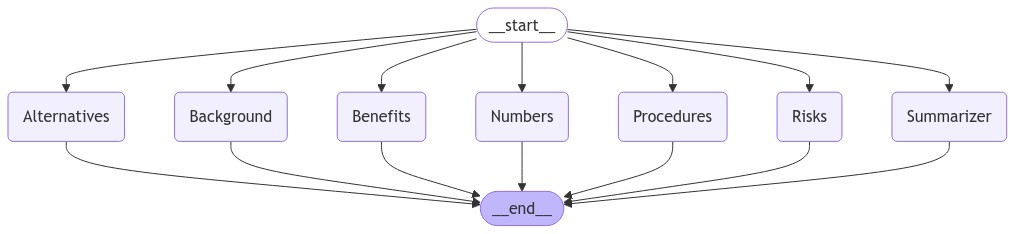

In [12]:
# Now construct the graph.  My first attempt simply linked them in
# sequence to mimic the brute force method done earlier.  But this
# graph runs the agents in parallel.

uncompiled_graph = StateGraph(AgentState)

# Add nodes
uncompiled_graph.add_node("Summarizer", summary_node)
uncompiled_graph.add_node("Background", background_node)
uncompiled_graph.add_node("Numbers", number_of_participants_node)
uncompiled_graph.add_node("Procedures", study_procedures_node)
uncompiled_graph.add_node("Alternatives", alt_procedures_node)
uncompiled_graph.add_node("Risks", risks_node)
uncompiled_graph.add_node("Benefits", benefits_node)

# Edges from the START
uncompiled_graph.add_edge(START,"Summarizer")
uncompiled_graph.add_edge(START,"Background")
uncompiled_graph.add_edge(START,"Numbers")
uncompiled_graph.add_edge(START,"Procedures")
uncompiled_graph.add_edge(START,"Alternatives")
uncompiled_graph.add_edge(START,"Risks")
uncompiled_graph.add_edge(START,"Benefits")

# Edges to the END
uncompiled_graph.add_edge("Summarizer",END)
uncompiled_graph.add_edge("Background",END)
uncompiled_graph.add_edge("Numbers",END)
uncompiled_graph.add_edge("Procedures",END)
uncompiled_graph.add_edge("Alternatives",END)
uncompiled_graph.add_edge("Risks",END)
uncompiled_graph.add_edge("Benefits",END)

compiled_graph = uncompiled_graph.compile()

try:
    display(Image(compiled_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

## Now let's run the chain and produce the ICF!

In [13]:
start_time = time.time()
inputs = {"messages":[HumanMessage(content="")]}
result = compiled_graph.invoke(inputs)
end_time = time.time()
execution_time = end_time - start_time
print(f"Agent based (parallel) execution time: {execution_time:.2f} seconds.")

pieces_of_consent = [
    heading,
    result['summary'][-1].content,
    result['background'][-1].content,
    result['number_of_participants'][-1].content,
    result['study_procedures'][-1].content,
    result['alt_procedures'][-1].content,
    result['risks'][-1].content,
    result['benefits'][-1].content,
    boilerplate,
    part2
]
ICF_title = "Agent Written ICF"
makeMarkdown(pieces_of_consent, ICF_title)
print("Done")

Agent based (parallel) execution time: 17.11 seconds.


 
## Parental Permission, Teen Assent and Authorization Document

**Study Title:** PeRsonalizEd immunomodulation in pediatriC sepsIS-inducEd MODS (PRECISE)

**Principal Investigator:** Mark W. Hall

**Version Date:** October 14, 2024

**Source of Support:** Eunice Kennedy Shriver National Institute for Child Health and Human Development (NICHD)

---

<div style="text-align: center;">

## Part 1 of 2: MASTER CONSENT
</div>

**Parents/Guardians:**
You have the option of having your child or teen join a research study.
This is a parental permission form. It provides a summary of the information the research team
will discuss with you. If you decide that your child can take part in this study, you would sign
this form to confirm your decision. If you sign this form, you will receive a signed copy for your
records. *The word “you” in this form refers to your child/teen unless otherwise indicated.*

**Assent Teen Participants:**
This form also serves as an assent form. That means that if you
choose to take part in this research study, you would sign this form to confirm your choice. Your
parent or guardian would also need to give their permission and sign this form for you to join the
study

**Consent for Continued Participation (Participants who turn 18 during the study):**
This is a consent form for continued participation. It provides a summary of the information the
research team will discuss with you. If you decide that you would like to continue participating in
this research study, you would sign this form to confirm your decision. If you sign this form, you
will receive a signed copy of this form for your records.

---



---

## Study Summary

You are being invited to allow your child to participate in a research study because your child is potentially eligible due to their admission to the Pediatric or Cardiac Intensive Care Unit with sepsis-induced multiple organ dysfunction syndrome (MODS). This study, known as the PRECISE study, aims to explore new ways to treat children with sepsis-induced MODS by personalizing their care based on their immune system's response to the infection.

Sepsis is a serious condition that occurs when the body's response to an infection causes injury to its own tissues and organs. In some cases, this can lead to multiple organ dysfunction syndrome (MODS), where two or more organ systems in the body stop working properly. The current treatment for sepsis mainly involves antibiotics and supportive care, such as fluids and medications to support blood pressure. However, these treatments are not tailored to the specific needs of each child, and there is a need for more personalized approaches.

The PRECISE study is designed to address this need by identifying specific immune system patterns, or "phenotypes," in children with sepsis-induced MODS. By understanding these patterns, researchers hope to provide treatments that are more closely aligned with each child's unique immune response. The study involves two main trials: the GRACE-2 trial, which tests a drug called GM-CSF to boost the immune system, and the TRIPS trial, which tests a drug called anakinra to reduce inflammation. Both drugs are being compared to a placebo, which is a substance with no active ingredients, to see if they are effective in improving outcomes for children with sepsis-induced MODS.

Participation in this study is entirely voluntary, and you can choose to withdraw your child at any time without affecting their medical care. If you decide to allow your child to participate, they will undergo a series of tests to determine their immune phenotype. Based on these results, they may be enrolled in one of the trials or placed in an observational group if they do not meet the criteria for the trials.

There are potential risks and benefits to participating in this study. The risks include possible side effects from the study drugs, such as fever, chills, or allergic reactions. However, these risks are considered to be low, and the study team will closely monitor your child for any adverse effects. The potential benefits include the possibility of improved treatment outcomes for your child and the opportunity to contribute to research that may help other children with sepsis in the future.

It is important to understand that participation in this study is not required for your child to receive the best possible care for their condition. The decision to participate should be made based on a careful consideration of the potential risks and benefits, and you are encouraged to ask any questions you may have before making a decision.

Thank you for considering this opportunity to contribute to important research that aims to improve the care and outcomes for children with sepsis-induced MODS.

---

## Background

You are being approached to participate in a study focused on improving the treatment of sepsis-induced multiple organ dysfunction syndrome (MODS) in children. Sepsis is a serious medical condition that occurs when the body's response to an infection causes widespread inflammation, leading to organ failure. MODS is a severe complication of sepsis where multiple organs in the body stop functioning properly. This condition is particularly dangerous in children and can lead to significant morbidity and mortality.

The study you are being considered for is called the "PeRsonalizEd immunomodulation in pediatriC sepsIS-inducEd MODS" (PRECISE) study. This research aims to explore new ways to treat sepsis-induced MODS by tailoring treatments to the specific immune responses of individual patients. The study is being conducted by the Collaborative Pediatric Critical Care Research Network, which includes several leading children's hospitals and research centers.

The PRECISE study is based on the understanding that children with sepsis-induced MODS can have different immune responses. Some children may have an overactive immune response, while others may have an underactive one. The study aims to identify these differences through a process called immunophenotyping, which involves analyzing blood samples to understand the immune system's behavior in each child.

Once the immune response is understood, the study will use two different interventions to try to improve outcomes. The first intervention is called GM-CSF (Granulocyte-Macrophage Colony-Stimulating Factor), which is a naturally occurring protein in the body that stimulates the production of white blood cells. This intervention is being tested in a trial called GRACE-2, which aims to reverse immunoparalysis, a condition where the immune system is too weak to fight infections effectively.

The second intervention involves a drug called anakinra, which is used to reduce inflammation by blocking a specific protein in the immune system known as interleukin-1. This intervention is part of the TRIPS trial, which targets children with excessive inflammation. By reducing inflammation, anakinra may help prevent further organ damage and improve recovery.

The scientific rationale behind these interventions is based on previous research that has shown the potential benefits of modulating the immune system in sepsis. For instance, GM-CSF has been used safely in other medical conditions to boost the immune system, and anakinra has been effective in reducing inflammation in diseases like rheumatoid arthritis.

By participating in this study, you will be contributing to important research that could lead to better treatments for sepsis-induced MODS in children. The goal is to personalize treatment based on each child's unique immune response, potentially improving survival rates and reducing the severity of organ dysfunction. Your involvement could help advance medical knowledge and lead to more effective therapies for children facing this life-threatening condition.

---

## Number of Participants

This study, titled "PeRsonalizEd immunomodulation in pediatriC sepsIS-inducEd MODS (PRECISE)," is being conducted by the Collaborative Pediatric Critical Care Research Network (CPCCRN), which includes multiple hospitals such as Children's Hospital of Colorado, Children's Hospital of Los Angeles, and others. The study is supported by the Eunice Kennedy Shriver National Institute for Child Health and Human Development (NICHD). The total number of participants planned for enrollment in the study is up to 1,095 patients. The study aims to accrue 500 patients specifically into the TRIPS trial component. The enrollment period for the study is expected to span a duration that allows for the comprehensive collection of data necessary to achieve the study's objectives. Participants will be enrolled from various CPCCRN-affiliated centers, ensuring a diverse and representative sample of the pediatric population affected by sepsis-induced multiple organ dysfunction syndrome (MODS).

---

## Study Procedures

### Screening and Enrollment

You will be evaluated for eligibility to participate in this study if you are admitted to the pediatric or cardiac intensive care unit. If you meet the initial criteria, we will record your information in our data system. If you are eligible, a member of our research team will approach your legal guardian(s) to discuss the study and offer the opportunity for you to participate. Your participation will involve immune phenotyping and potentially being part of an interventional trial based on the results of your immune phenotyping.

### Immune Phenotyping

On the second day after the onset of sepsis-induced multiple organ dysfunction syndrome (MODS), we will perform immune function testing. This involves drawing approximately 2 milliliters of blood to measure your immune response and levels of certain inflammatory markers. The blood sample will be processed on-site and then shipped to a specialized laboratory for analysis. The results will help us determine your immune status and whether you qualify for further study interventions.

### Randomization and Study Drug Administration

If your immune phenotyping results indicate that you are eligible, you will be randomly assigned to receive either the study drug or a placebo. This process is called randomization and ensures that each participant has an equal chance of receiving the study drug. The study drug will be administered intravenously, meaning it will be given through a vein, over a period of time. The specific drug and dosage will depend on your immune status as determined by the phenotyping results.

#### GRACE-2 Study Drug Administration

If you are part of the GRACE-2 trial, you will receive the study drug or placebo intravenously over at least six hours daily for seven days. Before receiving the first and fourth doses, we will check your white blood cell count to ensure it is safe to proceed with the treatment. If your white blood cell count is too high, the study drug will be temporarily withheld until it is safe to continue.

#### TRIPS Study Drug Administration

If you are part of the TRIPS trial, you will receive the study drug or placebo every 12 hours for seven days. The drug will be infused over one hour each time. If you have severe renal dysfunction, the dose may be adjusted to ensure safety.

### Follow-up Immune Phenotyping

Throughout the study, we will perform follow-up immune function testing to monitor your response to the study drug. This involves additional blood draws to measure your immune response and inflammatory markers. These follow-up tests will occur twice weekly for two weeks and will help us understand how the study drug affects your immune system over time.

### Biorepository Sample Collection

As part of the study, we will collect additional biological samples, including blood and, if applicable, endotracheal aspirates. These samples will be used to answer questions about the biology of immune function and inflammation in children with sepsis-induced MODS. The total volume of blood collected will be adjusted based on your weight to ensure safety. These samples will be stored and may be used for future research related to this study.

### Data Collection

We will collect various types of data throughout the study, including demographic information, eligibility data, and details about your medical history and current health status. We will also record information about the administration of the study drug, any adverse events, and your overall progress during the study.

### Monitoring and Safety

Your safety is our top priority. We will closely monitor your health throughout the study, including regular assessments of your vital signs, laboratory results, and any changes in your condition. If you experience any adverse events or if your condition changes, we will take appropriate action to ensure your safety.

### Discontinuation or Withdrawal

You may be withdrawn from the study if you or your legal guardian decide to discontinue participation, or if it is determined that it is not in your best interest to continue. If you are withdrawn, we will stop all study procedures and data collection, but we will continue to review any data collected prior to your withdrawal.

### Conclusion

These procedures are designed to help us understand the effects of the study drug on children with sepsis-induced MODS and to improve outcomes for future patients. Your participation is valuable and contributes to important research in pediatric critical care.

---

## Alternative Procedures

Your participation in this study is entirely voluntary. You do not need to be part of this study to receive high-quality care for sepsis-induced multiple organ dysfunction syndrome (MODS) in a pediatric intensive care unit. The medical team will continue to provide state-of-the-art critical care based on current medical standards, regardless of your decision to participate. This includes the use of antibiotics and supportive care measures such as fluid resuscitation and the use of medications to support heart and lung function. 

Currently, monitoring of immune function and personalized immunomodulation are not part of routine care in pediatric ICUs. The study aims to explore whether specific treatments can improve outcomes by targeting the immune system, but these treatments are not yet standard practice. If you choose not to participate, your child will still receive all the necessary medical interventions that are typically used to manage sepsis and MODS. 

You can decide to stop participating in the study at any time, and this will not affect the care your child receives. If you choose to withdraw from the study, the medical team will continue to provide all necessary treatments as per usual care protocols. Your decision to participate or not will not impact the quality of care your child receives in any way.

---

## Risks

Participating in this study involves several risks that you should be aware of before deciding to take part. These risks are associated with the study drugs, procedures, and data collection. While we have taken steps to minimize these risks, it is important to understand them fully. Additionally, there may be unforeseeable risks that we cannot predict at this time.

### Risks Associated with Study Drugs

#### GM-CSF (Granulocyte Macrophage-Colony Stimulating Factor)

GM-CSF is a medication used to stimulate the production of white blood cells. It is generally safe, but there are potential risks:

- **Fever and Chills**: You may experience fever and chills as your body responds to the medication.
- **Bone Pain**: Some participants report bone pain, which is usually mild and temporary.
- **Dyspnea (Difficulty Breathing)**: There is a small risk of experiencing difficulty breathing.
- **Tachycardia (Increased Heart Rate)**: Your heart rate may increase temporarily.
- **Peripheral Edema (Swelling)**: Rapid infusion of GM-CSF can cause swelling in the limbs.
- **Pericardial Effusion (Fluid Around the Heart)**: Although rare, there is a risk of fluid accumulation around the heart.
- **Hypersensitivity Reactions**: Allergic reactions, including rash and itching, may occur.

#### Anakinra

Anakinra is used to reduce inflammation by blocking a specific protein in the body. It is generally safe, but there are potential risks:

- **Increased Risk of Infections**: Anakinra may increase your risk of infections, as it affects the immune system.
- **Neutropenia (Low White Blood Cell Count)**: There is a risk of a decrease in white blood cells, which can make you more susceptible to infections.
- **Hypersensitivity Reactions**: Rarely, severe allergic reactions such as anaphylaxis (a life-threatening allergic reaction) can occur.

### Risks Associated with Biological Sampling

#### Blood Sampling

Blood samples will be collected as part of the study. The risks associated with blood sampling include:

- **Pain and Bruising**: You may experience pain and bruising at the site where the blood is drawn.
- **Bleeding**: There is a small risk of bleeding, especially if you have a bleeding disorder.
- **Infection**: Although rare, there is a risk of infection at the site of the blood draw.
- **Anemia**: Frequent blood draws can lead to a low red blood cell count, known as anemia, which may require treatment.

#### Tracheal Aspirates

For participants with a breathing tube, tracheal aspirates may be collected:

- **Discomfort**: The procedure may cause discomfort or coughing.
- **Bleeding**: There is a small risk of bleeding from the airway.
- **Infection**: There is a risk of introducing infection into the airway.

### Risks Associated with Data Collection

#### Loss of Confidentiality

While we take extensive measures to protect your personal information, there is a minimal risk of loss of confidentiality. We use secure data management systems to minimize this risk.

### Unforeseeable Risks

As with any clinical study, there may be risks that are currently unknown. These unforeseeable risks could potentially arise from the study drugs, procedures, or other aspects of the study. We will monitor all participants closely and inform you of any new risks that are identified during the study.

### Conclusion

Your safety is our top priority, and we have implemented measures to minimize these risks. However, it is important to weigh these risks against the potential benefits of participating in the study. If you have any questions or concerns about these risks, please discuss them with the study team before deciding to participate.

---

## Benefits

### Potential Benefits for You

Participating in this study may offer you potential benefits, although it is important to understand that the effectiveness of the intervention is not yet known. The primary goal of this study is to improve outcomes for children with sepsis-induced multiple organ dysfunction syndrome (MODS) by personalizing immune modulation based on individual immune phenotypes. If you are enrolled in the GRACE-2 trial, you may receive granulocyte macrophage-colony stimulating factor (GM-CSF), which is being investigated for its potential to reverse immunoparalysis and enhance your immune response. This could potentially lead to a reduction in the duration and severity of organ dysfunction, and possibly improve your overall recovery from sepsis-induced MODS.

If you are enrolled in the TRIPS trial, you may receive anakinra, a medication that targets inflammation. This could potentially help in reducing the inflammatory response associated with sepsis, which might lead to a quicker resolution of organ dysfunction and a decrease in the risk of further complications. The study aims to tailor the treatment to your specific immune response, which could enhance the effectiveness of the intervention.

While these potential benefits are promising, it is crucial to note that there is no guarantee that you will experience any direct health benefits from participating in this study. The interventions are experimental, and their efficacy in improving outcomes for sepsis-induced MODS is still being evaluated.

### Potential Benefits for Others

Your participation in this study could contribute significantly to the advancement of medical knowledge and the development of more effective treatments for sepsis-induced MODS in children. By helping researchers understand how personalized immune modulation can impact the course of this condition, you are playing a vital role in potentially improving the standard of care for future patients.

The data collected from your participation will help researchers identify specific immune phenotypes and how they respond to different treatments. This information could lead to the development of targeted therapies that are more effective and have fewer side effects than current treatment options. Additionally, the study may uncover new insights into the mechanisms of sepsis and MODS, which could inform the creation of novel therapeutic strategies.

Furthermore, the knowledge gained from this study may help healthcare providers better understand the complexities of sepsis-induced MODS and improve the management of this condition in pediatric intensive care units. Your involvement could ultimately lead to better outcomes for countless children who face similar health challenges in the future.

In summary, while the direct benefits to you are uncertain, your participation is invaluable in advancing the understanding and treatment of sepsis-induced MODS, potentially benefiting many others in the years to come.

---

 
## Right of the Investigator to Withdraw Participants
The investigator can withdraw you from the study without your approval.  If at any time the
investigator believes participating in the study is not the best choice of care, the study
may be stopped and other care prescribed.  If unexpected medical problems come up, the investigator
may decide to stop your participation in the study.

---
## New Information
Sometimes during the course of a research project, new information becomes available about the
drugs that are being studied. If this happens, your research doctor will tell you about it and discuss
with you whether you want to continue in the study. If you decide to continue in the study, you
may be asked to sign an updated consent form. Also, on receiving new information the research
doctor might consider it to be in your best interests to withdraw you from the study. He/she will
explain the reasons and arrange for your medical care to continue.

---

## Costs and Compensation to Participants
While you are in this study, the cost of your usual medical care - procedures, medications and
doctor visits - will continue to be billed to you or your insurance. There will be no additional costs
to you for your participation in this study. You will receive up to \$50 to compensate you for your
time when completing the follow-up surveys at the 3- and 12-month time points. You will receive
\$25 for each follow-up period once we receive your answers to the surveys. Any tests that are
performed or medications administered solely for the purposes of being in this study will be paid
for by the research doctor. The National Institutes of Health is providing funding for this study.

---

## Single IRB Contact
**Institutional Review Board:** The University of Utah Institutional Review Board (IRB) is
serving as the single IRB (SIRB) for this study. Contact the SIRB if you have questions, complaints
or concerns which you do not feel you can discuss with the investigator. The University of Utah
IRB may be reached by phone at (801) 581-3655 or 
by e-mail at irb@hsc.utah.edu.



---

 
## Parental Permission, Teen Assent and Authorization Document

**Study Title:** PeRsonalizEd immunomodulation in pediatriC sepsIS-inducEd MODS (PRECISE)

**Principal Investigator:** Mark W. Hall

**Source of Support:** Eunice Kennedy Shriver National Institute for Child Health and Human Development (NICHD)

---

<div style="text-align: center;">

## Part 2 of 2: SITE SPECIFIC INFORMATION
</div>

This section of the consent form, as well as signature pages, are very specific
to individual sites, and the Clinical Trial Accelerator does not have the ability
to create this section.principal_investigator

---



Markdown document has been created: /Users/jmichaeldean/clinical-trials/experimental/Agent Written ICF.md
Done
